#  PRCP - 1001 - Rice Leaf Disease Detection Using CNN



<div style="text-align: center; margin-left: -5%; font-size: 30px;">
    <b>TASK-1 : Data Analysis Report for Image Classification Using CNN</b>
</div>


### *1) Exploratory Data Analysis (EDA)*

##### Identifying Classes and Bar chart representation

Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Class Distribution (Valid Images Only): {'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf smut': 39}


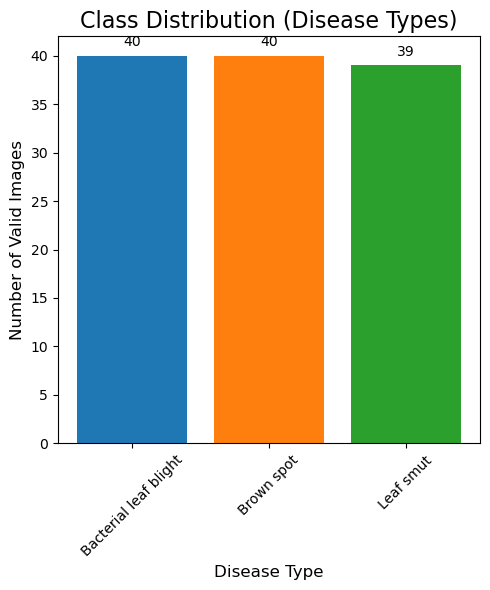

In [17]:
import os
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = r"C:\Users\imjee\Riceleaf_detection\data"

# List classes (folders)
classes = os.listdir(dataset_path)
print("Classes:", classes)

# Count valid images recursively
class_counts = {}
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    image_files = []
    
    # Traverse subfolders to find image files
    for root, _, files in os.walk(class_path):
        image_files.extend(
            file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))
        )
    
    class_counts[cls] = len(image_files)

print("Class Distribution (Valid Images Only):", class_counts)

# Generate a color palette
colors = plt.cm.tab10.colors  # Use a color palette with 10 unique colors

# Create a bar chart with different colors for each class
plt.figure(figsize=(5, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors[:len(classes)])  # Assign colors

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, str(yval), ha='center', fontsize=10)

# Add chart title and labels
plt.title("Class Distribution (Disease Types)", fontsize=16)
plt.xlabel("Disease Type", fontsize=12)
plt.ylabel("Number of Valid Images", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the chart
plt.show()


##### Displaying Sample Images of each class

Sample images from class: Bacterial leaf blight


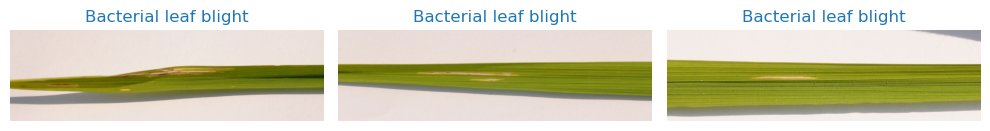

Sample images from class: Brown spot


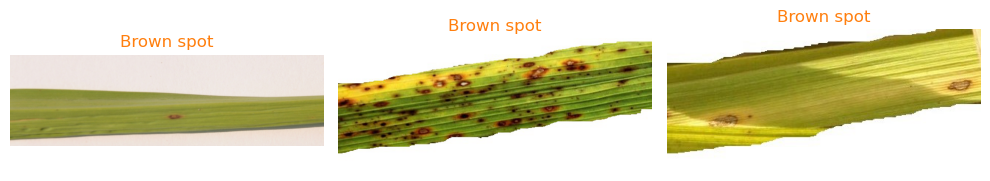

Sample images from class: Leaf smut


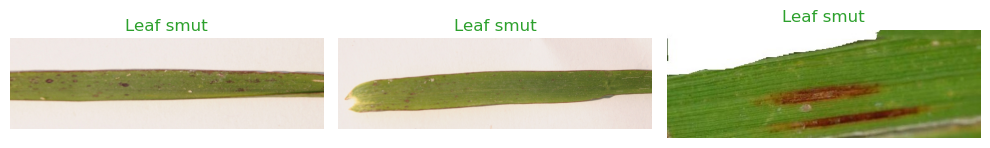

In [22]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_sample_images(dataset_path, classes, num_samples=3):
    colors = plt.cm.tab10.colors  # Use a color palette for titles

    for idx, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        
        # Check if the folder exists
        if not os.path.exists(class_path):
            print(f"Class folder not found: {class_path}")
            continue

        image_files = []
        for root, _, files in os.walk(class_path):
            image_files.extend(
                os.path.join(root, file)
                for file in files
                if file.lower().endswith(('.png', '.jpg', '.jpeg'))
            )

        if len(image_files) < num_samples:
            print(f"Not enough images in {cls}. Found {len(image_files)}, but {num_samples} requested.")
            num_samples = len(image_files)

        if num_samples == 0:
            print(f"No valid image files found in {class_path}")
            continue

        images = random.sample(image_files, num_samples)
        print(f"Sample images from class: {cls}")

        fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
        for i, img_path in enumerate(images):
            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].axis("off")
                axes[i].set_title(cls, color=colors[idx % len(colors)])  # Assign a color for the title
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                axes[i].axis("off")
        plt.tight_layout()
        plt.show()

dataset_path = r"C:\Users\imjee\Riceleaf_detection\data"
classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]
display_sample_images(dataset_path, classes)


### *2) Data Preprocessing*



#####  Import all the Dependencies

In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [34]:
BATCH_SIZE = 16 
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

#### Import data into tensorflow dataset object

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\imjee\Riceleaf_detection\data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [38]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

#### Visualize some of the images from our dataset

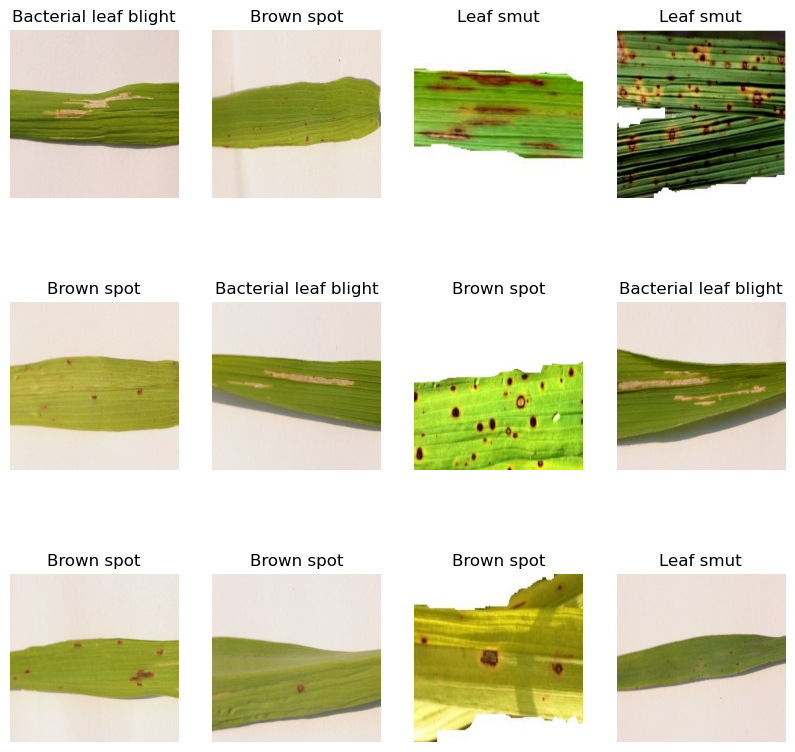

In [41]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Splitting the dataset

Dataset should be splitted into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

For Training= 70% ,Validation= 20% ,Testing= 10% 

In [62]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [64]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [66]:
len(train_ds)

5

In [68]:
len(val_ds)

1

In [70]:
len(test_ds)

2

#### Cache, Shuffle, and Prefetch the Dataset

In [73]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<div style="text-align: center;margin-left: -5%;  font-size: 30px;">
    <b>TASK-2 : Model Building Using CNN</b>
</div>

#### Creating a Layer for Resizing and Normalization


In [80]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
resize_and_rescale = Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### *2) Model building without Augumentation*

In [83]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_1.build(input_shape=input_shape)

C:\Users\imjee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (16, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (16, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (16, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (16, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (16, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (16, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (16, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (16, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (16, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (16, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (16, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (16, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (16, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (16, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_1.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds1,
    verbose=1,
    epochs=50,
)

In [91]:
history = model_1.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 554ms/step - accuracy: 0.4286 - loss: 1.0866 - val_accuracy: 0.3750 - val_loss: 1.0949
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.2831 - loss: 1.1011 - val_accuracy: 0.3125 - val_loss: 1.0991
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - accuracy: 0.3578 - loss: 1.0919 - val_accuracy: 0.5625 - val_loss: 1.0928
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.4993 - loss: 1.0852 - val_accuracy: 0.4375 - val_loss: 1.0929
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.4926 - loss: 1.0759 - val_accuracy: 0.3750 - val_loss: 1.0818
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.4092 - loss: 1.0517 - val_accuracy: 0.4375 - val_loss: 1.0736
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.5445 - loss: 1.0224 - val_accuracy: 0.4375 - val_loss: 1.0646
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.5475 - loss: 0.9538 - val_accuracy: 0.5625 - val_loss:

In [93]:
scores = model_1.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8125 - loss: 1.1229


In [95]:
scores

[0.9036993980407715, 0.84375]

#### Without Augumentation, **"Accuracy=0.84 , Loss= 0.90"**

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#### Plotting Accuracy and Loss curves 

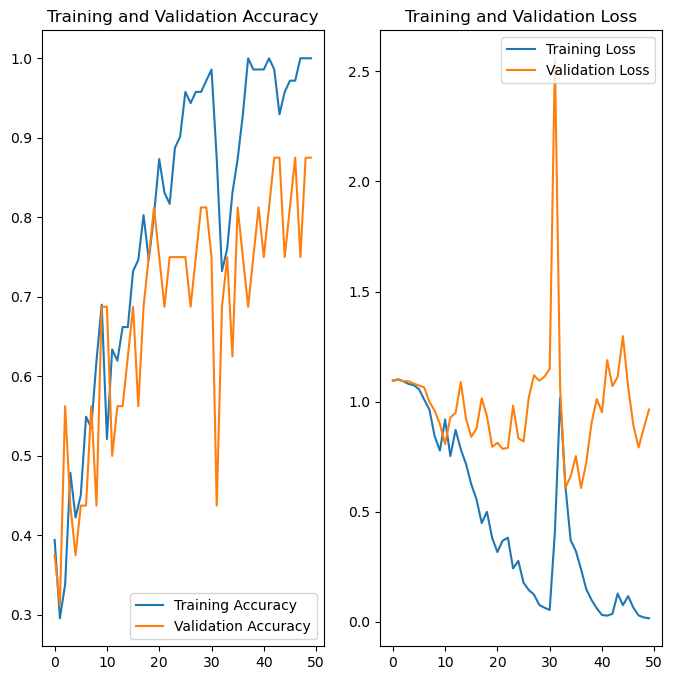

In [109]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix and Classification report for model performance

In [112]:
def predict(model_1, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_1.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

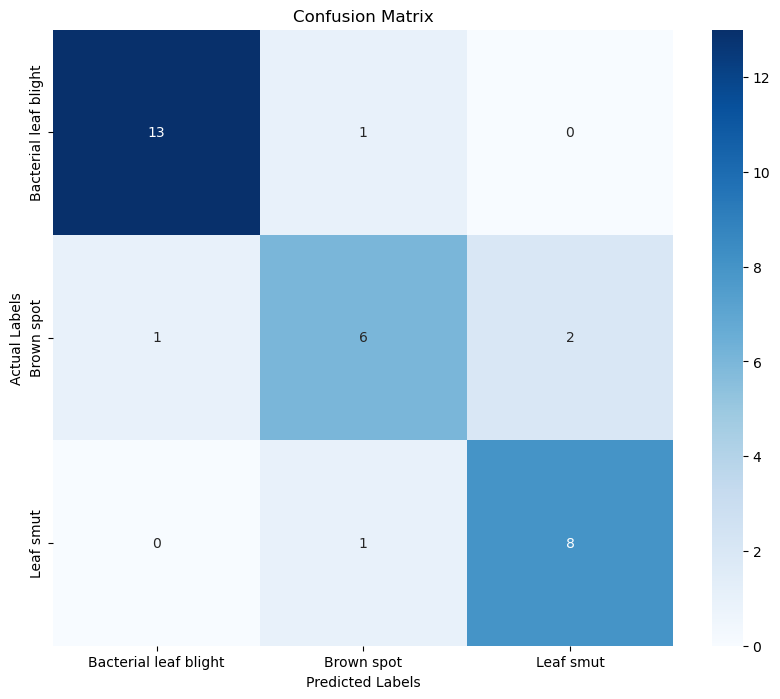

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.93      0.93      0.93        14
           Brown spot       0.75      0.67      0.71         9
            Leaf smut       0.80      0.89      0.84         9

             accuracy                           0.84        32
            macro avg       0.83      0.83      0.83        32
         weighted avg       0.84      0.84      0.84        32



In [114]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

actual_labels = []
predicted_labels = []
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, _ = predict(model_1, images[i])
        predicted_labels.append(predicted_class)
        actual_labels.append(class_names[int(labels[i])])

cm = confusion_matrix(actual_labels, predicted_labels, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)


<div style="text-align: center;margin-left: -5%;  font-size: 30px;">
    <b>TASK-3 : Data Augumentation Technique</b>
</div>

### *To precise prediction there are two ways of Data Augumentation*

1. By using Image Data Generator
2. Manual Image Augumentation pipeline

### **1) Using Image Data Generator**

In [132]:
import numpy as np

def dataset_to_numpy(ds):
    images = []
    labels = []
    for image_batch, label_batch in ds:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)
x_test, y_test = dataset_to_numpy(test_ds)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (71, 256, 256, 3), y_train shape: (71,)
x_val shape: (16, 256, 256, 3), y_val shape: (16,)
x_test shape: (32, 256, 256, 3), y_test shape: (32,)


In [134]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation
test_gen = ImageDataGenerator(rescale=1./255)  # Only rescaling for testing


train_generator = train_gen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_gen.flow(x_val, y_val, batch_size=BATCH_SIZE)
test_generator = test_gen.flow(x_test, y_test, batch_size=BATCH_SIZE)


### Model Building

In [136]:
model_2 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(CHANNELS, activation='softmax'),
])

model_2.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Compile the Model

In [149]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS, 
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    batch_size=BATCH_SIZE,
    verbose=1
)



Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step - accuracy: 0.8783 - loss: 0.3438 - val_accuracy: 0.8125 - val_loss: 0.5586
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - accuracy: 0.8518 - loss: 0.4990 - val_accuracy: 0.7500 - val_loss: 0.5584
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step - accuracy: 0.8499 - loss: 0.2886 - val_accuracy: 0.8125 - val_loss: 0.4407
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.7945 - loss: 0.3775 - val_accuracy: 0.8125 - val_loss: 0.3975
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.9183 - loss: 0.2633 - val_accuracy: 0.8750 - val_loss: 0.3168
Epoch 

In [147]:
test_loss, test_acc = model_2.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9583 - loss: 0.1776
Test accuracy: 0.96875
Test loss: 0.19132393598556519


#### With Image Data Generator **"Accuracy= 0.96, Loss= 0.1913**

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#### Plotting Accuracy and Loss curves for Imagedatagenerator

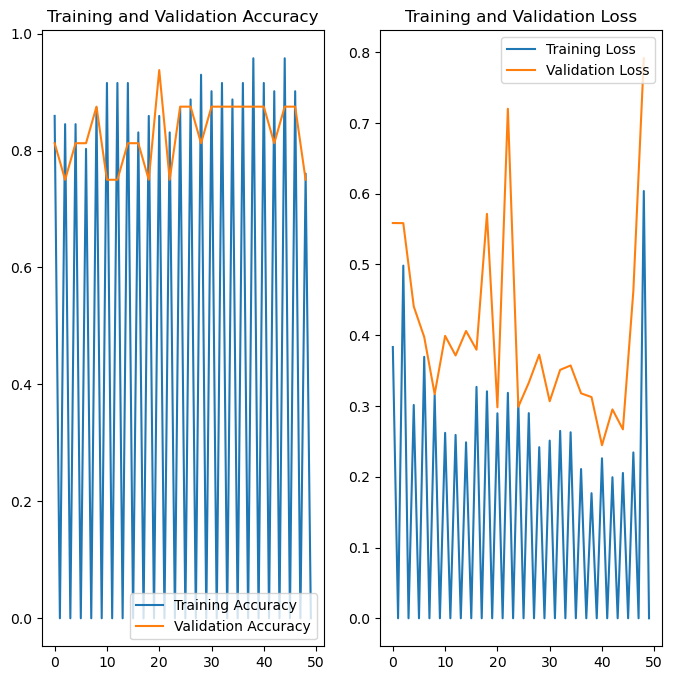

In [213]:
plt.figure(figsize=(8, 8))


plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(0, EPOCHS, 2), val_acc, label='Validation Accuracy')  
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(0, EPOCHS, 2), val_loss, label='Validation Loss')  
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


#### Confusion Matrix and Classification report for model performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

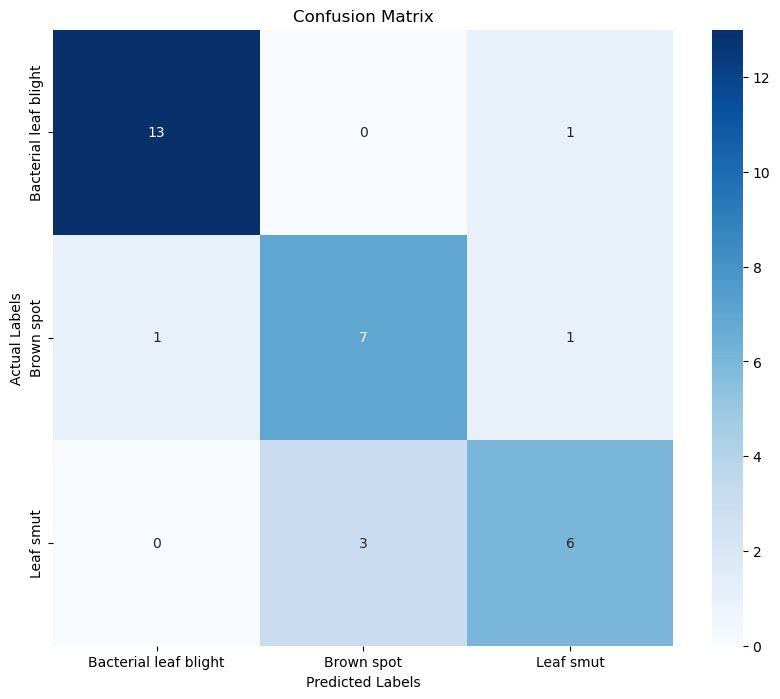

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.93      0.93      0.93        14
           Brown spot       0.70      0.78      0.74         9
            Leaf smut       0.75      0.67      0.71         9

             accuracy                           0.81        32
            macro avg       0.79      0.79      0.79        32
         weighted avg       0.81      0.81      0.81        32



In [171]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


actual_labels = []
predicted_labels = []
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, _ = predict(model_2, images[i])
        predicted_labels.append(predicted_class)
        actual_labels.append(class_names[int(labels[i])])
cm = confusion_matrix(actual_labels, predicted_labels, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)


### **2) Using Manual Augumentation Pipeline**

In [174]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [177]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Model Building

In [180]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_3 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_3.build(input_shape=input_shape)
model_3.summary()

C:\Users\imjee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (16, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (16, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (16, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (16, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (16, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (16, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (16, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (16, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (16, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (16, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (16, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (16, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (16, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (16, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (16, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the Model

In [189]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model_3.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - accuracy: 0.7160 - loss: 0.7423 - val_accuracy: 0.8750 - val_loss: 0.4864
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.7910 - loss: 0.5294 - val_accuracy: 0.6250 - val_loss: 0.5896
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.7717 - loss: 0.5671 - val_accuracy: 0.6875 - val_loss: 0.5716
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.6705 - loss: 0.6775 - val_accuracy: 0.6875 - val_loss: 0.5279
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.7785 - loss: 0.6049 - val_accuracy: 0.8125 - val_loss: 0.4800
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.7887 - loss: 0.4097 - val_accuracy: 0.8125 - val_loss: 0.4418
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.8738 - loss: 0.3629 - val_accuracy: 0.6875 - val_loss: 0.5245
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.7984 - loss: 0.5049 - val_accuracy: 0.8125 - val_loss:

In [191]:
scores = model_3.evaluate(test_ds)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9167 - loss: 0.2327


In [226]:
history.history.keys()
type(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Plotting the Accuracy and Loss Curves for Manual Augumentation 

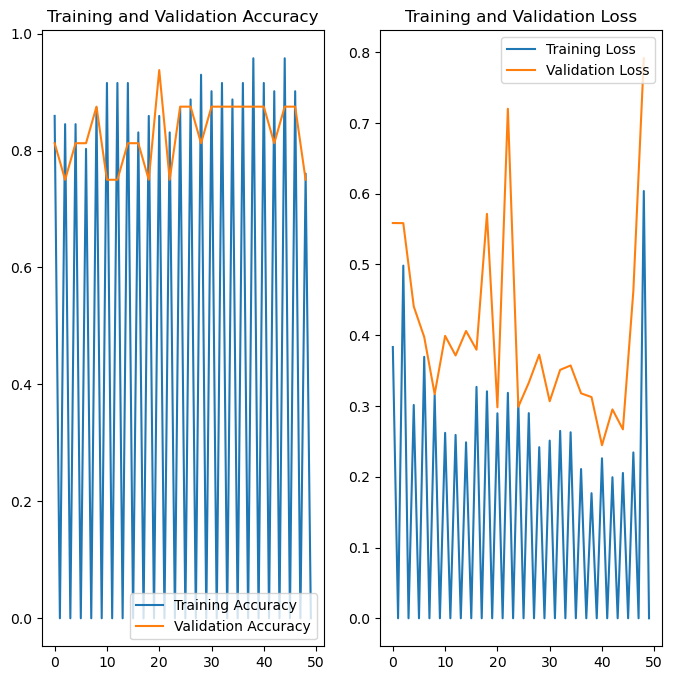

In [201]:
plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(0, EPOCHS, 2), val_acc, label='Validation Accuracy')  # Adjusted range
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(0, EPOCHS, 2), val_loss, label='Validation Loss')  # Adjusted range
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


#### Confusion Matrix and Classification report for model performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

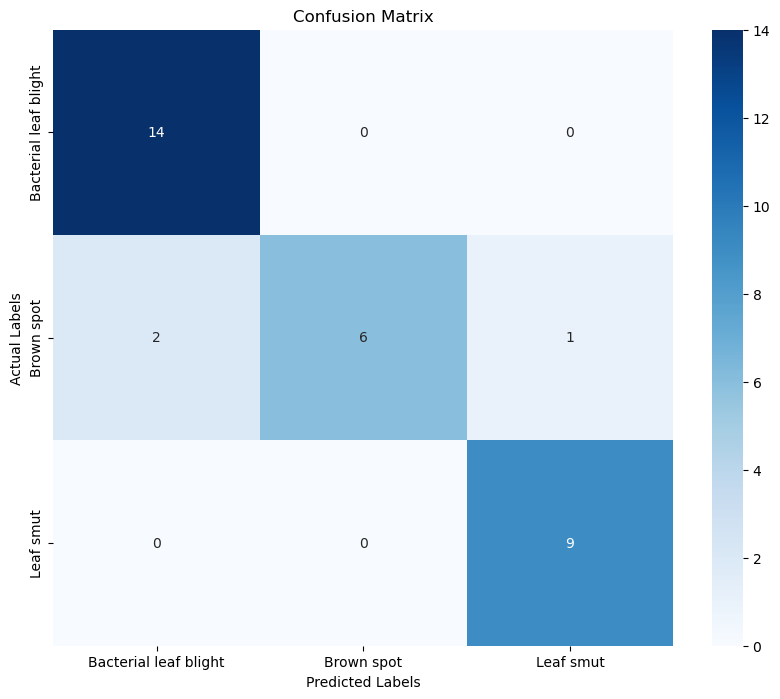

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.88      1.00      0.93        14
           Brown spot       1.00      0.67      0.80         9
            Leaf smut       0.90      1.00      0.95         9

             accuracy                           0.91        32
            macro avg       0.92      0.89      0.89        32
         weighted avg       0.92      0.91      0.90        32



In [229]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

actual_labels = []
predicted_labels = []

for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, _ = predict(model_3, images[i])
        predicted_labels.append(predicted_class)
        actual_labels.append(class_names[int(labels[i])])
cm = confusion_matrix(actual_labels, predicted_labels, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)


### Prediction on a sample image

first image to predict
actual label: Bacterial leaf blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
predicted label: Bacterial leaf blight


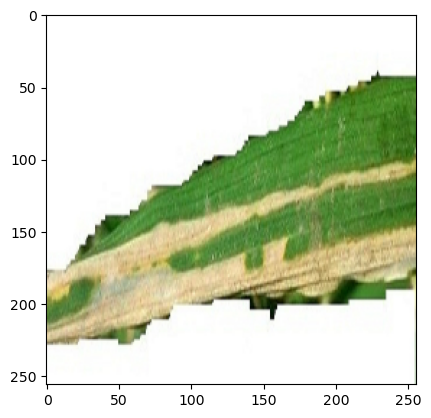

In [118]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

###  function for inference

In [240]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Running inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


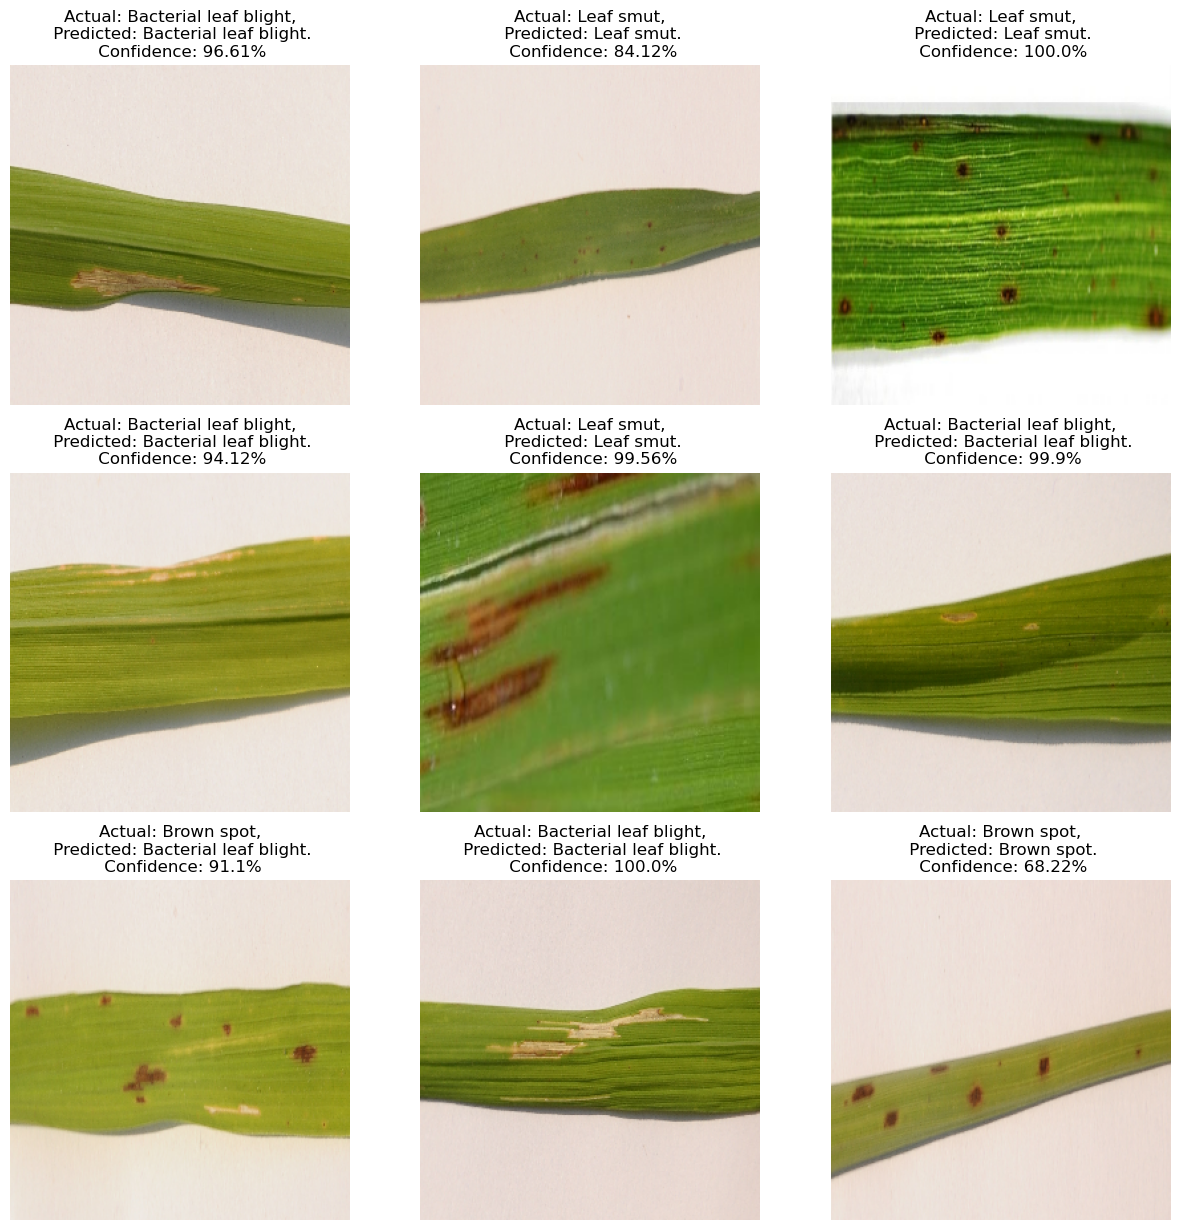

In [245]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_3, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model


In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model_1.save("../Riceleaf_disease.h5")

### Conclusion

#### This  project successfully implemented a deep learning-based approach to classify three major rice plant diseases:
Leaf Smut, Bacterial leaf blight, and Brown Spot. Through careful data preprocessing, exploratory data analysis (EDA), and the application of a convolutional neural network (CNN), the following outcomes were achieved:

#### Key Achievements:

A model Building is performed in three techniques:
  
  
  1).Model building without Augumentation (using CNN)

  
  2).By using Image Data Generator


3).Manual Image Augumentation pipeline 

 **Highest accuracy of 91%** was obitained in this technique ,indicating a reliable classification performance. 

Among the three techniques this **"Manual Image Augumentation Pipeline"** gives the best performance.

#### Challenges:


###### Dataset with Insufficient data.
###### Low Accuracy in Image data generator due to less data.
###### Data splitting is difficult while performing the trainning,testing,validation.

